In [36]:
from firestore_service import FirestoreService
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
firestore_service = FirestoreService()
step_history_df = firestore_service.read_collection_to_dataframe()
step_history_df

I0000 00:00:1724050225.542651 2302552 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,date,step_count
0,2023-08-18,0
1,2023-08-19,0
2,2023-08-20,0
3,2023-08-21,2158
4,2023-08-22,6821
...,...,...
361,2024-08-13,4154
362,2024-08-14,9040
363,2024-08-15,9181
364,2024-08-16,3004


In [23]:
## Analysis of week to yesterday
import pandas as pd

def create_week_to_yesterday_dates_df():
    ''' Returns a df with dates (2024-10-19 format) and day_of_week
    for a full week up to yesterday
    '''
    start_of_week_to_yesterday = pd.Timestamp.now() - pd.DateOffset(days=7)
    end_of_week_to_yesterday = pd.Timestamp.now() - pd.DateOffset(days=1)
    date_range = pd.date_range(start=start_of_week_to_yesterday, end=end_of_week_to_yesterday)

    df = pd.DataFrame({
        'date': date_range.strftime('%Y-%m-%d'),  # Format the date as 'YYYY-MM-DD'
        'day_of_week': date_range.strftime('%A')  # Get the day of the week name
    })
    df['date'] = pd.to_datetime(df['date'])

    return df


In [39]:
# df_wty = df[(df['date'] > start_of_week_to_yesterday) & (df['date'] <= end_of_week_to_yesterday)]

df_wty = create_week_to_yesterday_dates_df()
df_wty = pd.merge(df_wty, step_history_df, how='left', on='date')

,date,day_of_week,step_count
0,2024-08-12,Monday,8105.0
1,2024-08-13,Tuesday,4154.0
2,2024-08-14,Wednesday,9040.0
3,2024-08-15,Thursday,9181.0
4,2024-08-16,Friday,3004.0
5,2024-08-17,Saturday,606.0
6,2024-08-18,Sunday,NaN


In [34]:
# Typical week, based on last 3 months
import matplotlib.pyplot as plt

step_history_df['day_of_week'] = step_history_df['date'].dt.day_name()

dates_3m = pd.Timestamp.now() - pd.DateOffset(months=3)
df_3m = step_history_df[step_history_df['date'] > dates_3m]

df_3m_grouped = df_3m.groupby('day_of_week')['step_count'].mean().astype(int).reset_index()
df_3m_grouped = df_3m_grouped.rename(columns={'step_count': '3m_avg_steps_per_day'})
df_3m_grouped

,day_of_week,3m_avg_steps_per_day
0,Friday,6724
1,Monday,6519
2,Saturday,6330
3,Sunday,5296
4,Thursday,7098
5,Tuesday,7110
6,Wednesday,5469


In [41]:
df_wty = pd.merge(df_wty, df_3m_grouped, how='left', on='day_of_week')
df_wty

,date,day_of_week,step_count,3m_avg_steps_per_day
0,2024-08-12,Monday,8105.0,6519
1,2024-08-13,Tuesday,4154.0,7110
2,2024-08-14,Wednesday,9040.0,5469
3,2024-08-15,Thursday,9181.0,7098
4,2024-08-16,Friday,3004.0,6724
5,2024-08-17,Saturday,606.0,6330
6,2024-08-18,Sunday,NaN,5296


In [ ]:

avg_wty = int(df_wty['step_count'].mean())
avg_3m = int(df_3m_grouped['3m_avg_steps_per_day'].mean())
df_3m_grouped

2024-08-19 18:54:09,135 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-19 18:54:09,136 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-19 18:54:09,137 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-19 18:54:09,137 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


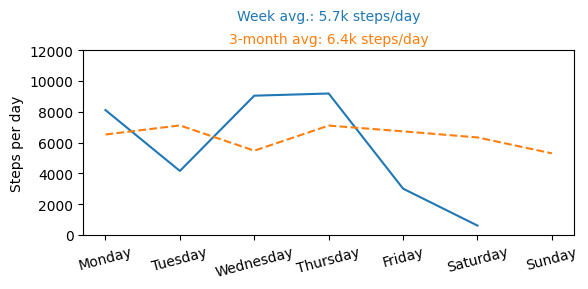

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

def format_steps(steps):
    if abs(steps) >= 1000:
        return f"{steps / 1000:.1f}k"
    else:
        return str(steps)

# Choose pretty colors for the lines
solid_line_color = '#1f77b4'  # A nice blue color
dotted_line_color = '#ff7f0e'  # A nice orange color

plt.figure(figsize=(6, 3))
plt.plot(df_wty['day_of_week'], df_wty['step_count'], linestyle='-', color=solid_line_color, label='Weekly Avg')
plt.plot(df_wty['day_of_week'], df_wty['3m_avg_steps_per_day'], linestyle='--', color=dotted_line_color, label='3-Month Avg')

# Set the title with colored text
title = (f'Week avg.: {format_steps(avg_wty)} steps/day\n')

plt.title(f'{title}', loc='center', fontsize=10, color=solid_line_color, pad=10)
plt.gca().text(0.5, 1.02, f'3-month avg: {format_steps(avg_3m)} steps/day', 
               fontsize=10, color=dotted_line_color, ha='center', va='bottom', transform=plt.gca().transAxes)

# Set labels
plt.ylabel('Steps per day')
plt.xticks(rotation=15)  # Rotate x-axis labels if needed
plt.ylim([0, max(df_wty['step_count'].max(), 12000)]) 

# Display the plot
plt.tight_layout()
plt.show()

In [10]:
full_day_order = df_wty['day_of_week']
day_order = [day for day in full_day_order if day in df_wty['day_of_week'].unique()]
df_3m_grouped['day_of_week'] = pd.Categorical(df_3m_grouped['day_of_week'], categories=day_order, ordered=True)
df_3m_grouped = df_3m_grouped.sort_values('day_of_week').reset_index(drop=True)
df_3m_grouped

,day_of_week,step_count
0,Monday,6519
1,Tuesday,7110
2,Wednesday,5469
3,Thursday,7098
4,Friday,6724
5,Saturday,6330
6,NaN,5296


In [92]:
import pandas as pd
import matplotlib.pyplot as plt


df2 = df.copy()
# Set the 'date' column as the DataFrame index
df2.set_index('date', inplace=True)

# Resample by week and calculate the mean
df_weekly = df2.resample('W').mean()

# Reset the index to have 'date' as a column again
df_weekly.reset_index(inplace=True)

# Plot the weekly average data
plt.figure(figsize=(10, 6))
plt.plot(df_weekly['date'], df_weekly['step_count'], marker='o', linestyle='-', color='g')

# Set the title and labels
plt.xlabel('Date')
plt.ylabel('Avg. steps/day')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

/var/folders/23/3390lh257x3gjtwt4s6s6bz00000gn/T/ipykernel_24754/450845970.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df3.resample('M').mean()


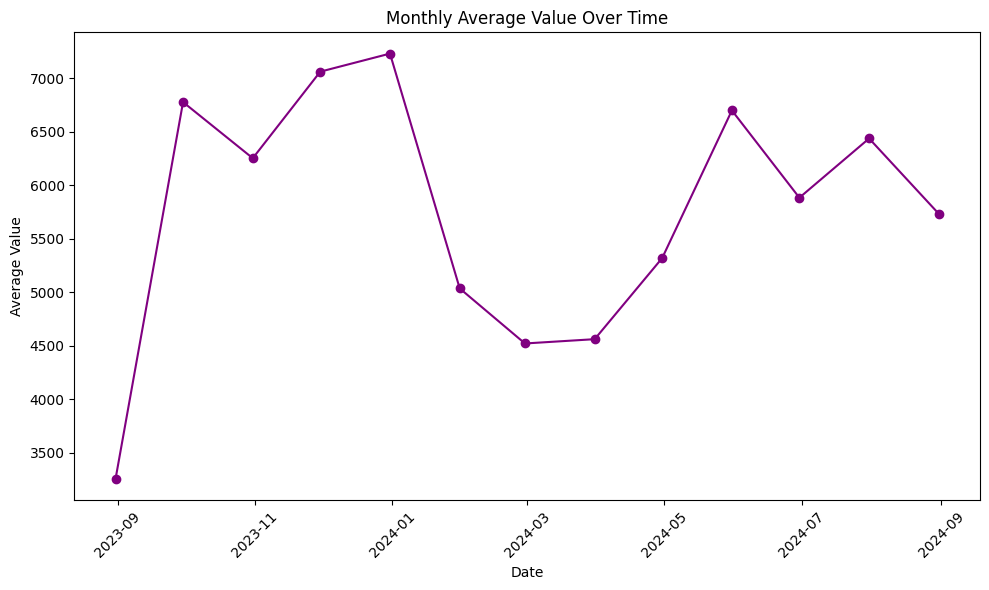

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df3 = df.copy()

# Set the 'date' column as the DataFrame index
df3.set_index('date', inplace=True)

# Resample by month and calculate the mean
df_monthly = df3.resample('M').mean()

# Reset the index to have 'date' as a column again
df_monthly.reset_index(inplace=True)

# Plot the monthly average data
plt.figure(figsize=(8, 4))
plt.plot(df_monthly['date'], df_monthly['step_count'], marker='o', linestyle='-', color='purple')

# Set the title and labels
plt.title('Daily average by Month')
plt.xlabel('Date')
plt.ylabel('Average Value')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()
